# A short unconference on Bayesian Stats
## Coding around Fitting a straight line problem (pymc3 based solution)

### M. Fouesneau

> This Notebook shows how to implement a straight line fitting using MCMC and an outlier mixture model.

In [ ]:
%%file requirements.txt
git+https://github.com/mfouesneau/ezdata
git+https://github.com/mfouesneau/mf_jupyter
numpy
scipy
matplotlib
#emcee
corner
seaborn
pandas
daft
pymc3
#pystan
#tqdm
#numpyro
#funsor

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt --quiet

In [ ]:
# Loading configuration
# Don't forget that mac has this annoying configuration that leads
# to limited number of figures/files
# ulimit -n 4096    <---- osx limits to 256

# Notebook matplotlib mode
%pylab inline                                 
# set for retina or hi-resolution displays
%config InlineBackend.figure_format='retina'  

import pylab as plt
import numpy as np
from ezdata.matplotlib import light_minimal
plt.style.use(light_minimal)
from corner import corner
from IPython.display import display, Markdown

Populating the interactive namespace from numpy and matplotlib


# Preliminary discussion around Bayesian statistics

As astronomers, we are interested in characterizing uncertainties as much as the point-estimate in our analyses. This means we want to infer the distribution of possible/plausible parameter values.

In the Bayesian context, the Bayes' theorem, also called chain rule of conditional probabilities, expresses how a degree of belief (prior), expressed as a probability, should rationally change to account for the availability of related evidence. 

$$P(A\mid B) = \frac{P(B \mid A) P(A)}{P(B)}$$

where $A$ and $B$ are ensembles of events. ($P(B) \neq 0$).

* $P(A\mid B)$ the probability of event $A$ occurring given that an event $B$ already occured. It is also called the posterior probability of $A$ given $B$.
* $P(B\mid A)$ is the probability of event $B$ occurring given that $A$ already occured. It is also called the likelihood of A given a fixed B.
* $P(A)$ and $P(B)$ are the probabilities of observing $A$ and $B$ independently of the other one. They are known as the marginal probabilities or prior probabilities.

We note that in this equation we can swap $A$ and $B$. The Bayesian framework only brings interpretations. One can see it as a knowledge refinement: given what I know about $A$ (e.g, gravity, stellar evolution, chemistry) what can we learn with new events $B$.

**A note about the proof**: The equation derives from a simple observation (geometry/ensemble theory).

The figure below gives the visual support 

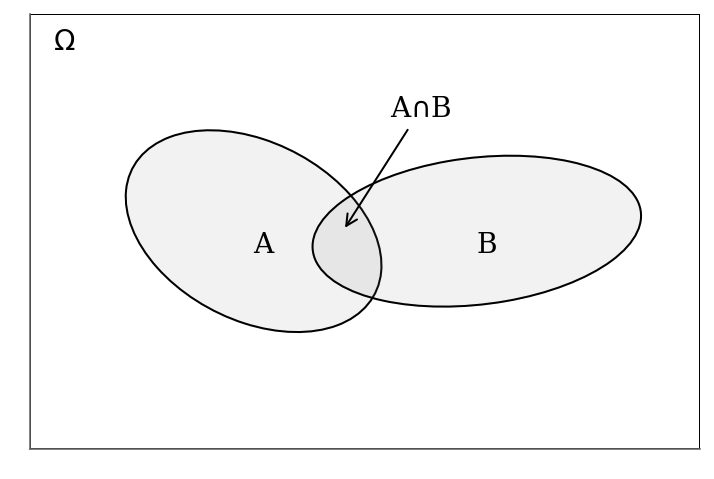

In [ ]:
from matplotlib.patches import Ellipse, Rectangle

ax = plt.subplot(111)

patches = [
    Ellipse((-1, 0), 2, 3, angle=30, facecolor='0.5', edgecolor='k', alpha=0.1),
    Ellipse((-1, 0), 2, 3, angle=30, facecolor='None', edgecolor='k'),
    Ellipse((1, 0), 3, 2, angle=15, facecolor='0.5', edgecolor='k', alpha=0.1),
    Ellipse((1, 0), 3, 2, angle=15, facecolor='None', edgecolor='k'),
    Rectangle((-3, -3), 6, 6, facecolor='None', edgecolor='k')
]
for patch in patches:
    ax.add_patch(patch)
    
plt.text(-2.8, 2.8, r'$\Omega$', va='top', ha='left', color='k')
plt.text(-1, 0, 'A', va='top', ha='left', color='k')
plt.text(1, 0, 'B', va='top', ha='left', color='k')

plt.annotate(r'A$\cap$B', (-0.2, 0.), 
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             horizontalalignment='center', verticalalignment='bottom',
             xytext=(0.5, 1.5))

plt.xlim(-3, 3)
plt.ylim(-3, 3)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

For any event $x$ from $\Omega$
$$
\begin{eqnarray}
P(x\in A \cap B) & = P(x\in A \mid x \in B) \cdot P(x\in B)\\
& = P(x\in B \mid x \in A) \cdot P(x\in A)
\end{eqnarray}
$$
which we can write in a more compact way as 
$$
\begin{eqnarray}
P(A, B \mid \Omega) & = P(A \mid B, \Omega) \cdot P(B \mid \Omega)\\
& = P(B \mid A, \Omega) \cdot P(A \mid \Omega)\\
\end{eqnarray}
$$
Note that, we explicitly noted $\Omega$ but it is commonly omitted.
The final equation of the Bayes' theorem derives from the rearanging the terms of the right hand-side equalities.

The equation itself is most commonly attributed to reverand Thomas Bayes in 1763, but also to Pierre-Simon de Laplace. However, the current interpretation and usage significantly expanded from its initial formulation.

# Straight line problem

In astronomy, we commonly have to fit a model
to data. A very typical example is the fit of a straight line to a set of points in a two-dimensional plane.
Astronomers are very good at finding a representation or a transformation of their data in which they can identify linear correlations (e.g., plotting in log-log space, action-angles for orbits, etc). 
Consequently, a polynomial remains a "line" in a more complicated representation space.

In this exercise, we consider a dataset with uncertainties along one axis only for simplicity, i.e. uncertainties along x negligible. These conditions are rarely met in practice but the principles remain similar. 
However, we also explore the outlier problem: bad data are very common in astronomy.

We emphasize the importance of having a "generative model" for the data, even an approximate one. 
Once there is a generative model, we have a direct computation of the likelihood of the parameters or the posterior probability distribution.

## Problem definition

We will fit a linear model to a dataset $\{(x_i, y_i, \sigma_i)\}$


$$ \hat{y}(x ~\mid~\alpha, \beta) = \alpha \cdot x + \beta.$$

Let's start by looking at the data.

## Generate dataset: Straight line with outliers

In [ ]:
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
sy = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

np.savetxt('line_outlier.dat', np.array([x, y, sy]).T)

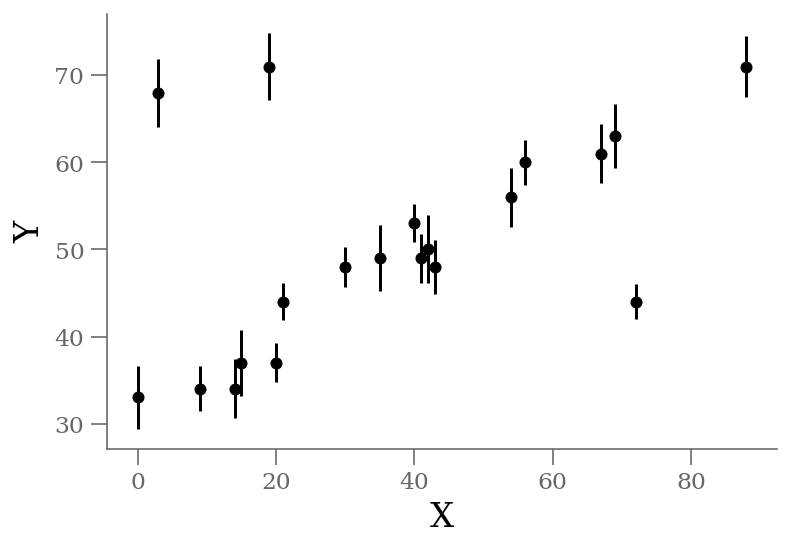

In [ ]:
x, y, sy = np.loadtxt('line_outlier.dat', unpack=True)
plt.errorbar(x, y, yerr=sy, marker='o', ls='None', ms=5, color='k');
plt.xlabel('X');
plt.ylabel('Y');

We see three outliers, but there is an obvious linear relation between the points overall.

## Blind fit: no outlier model

Let's see what happens if we fit the data without any outlier consideration.

#### Equations

We would like to fit a linear model to this above dataset:

$$ \hat{y}(x ~\mid~\alpha, \beta) = \alpha x + \beta $$


We commonly start with the Bayes's rule:

$$ P(\alpha, \beta \mid \{x_i\}, \{y_i\}, \{\sigma_i\}) \propto P(\{x_i\}, \{y_i\} | \alpha, \beta, \{\sigma_i\}) P(\alpha, \beta) $$

Hence we need to define our prior and likelihood

Given this model and the gaussian uncertainties on our data, we can compute a Gaussian likelihood for each point:
$$
P(x_i,y_i,~|~\alpha, \beta, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left[-\frac{1}{2\sigma_i^2}\left(y_i - {y}(x_i~|~\alpha, \beta)\right)^2\right]
$$
Note that $\sigma_i$ is on the right hand side of the $\mid$. It is because we assume given the Gaussian uncertainties when we write the likelihood that way.

The total likelihood is the product of all the individual likelihoods (as we assume independent measurements). 

For numerical stability reasons, it is preferable to take the log-likelihood of the data. We have:
$$
\log P(\{x_i, y_i\}~|~\alpha, \beta, \{\sigma_i\}) = \mathrm{const} - \sum_i \frac{1}{2\sigma_i^2}\left(y_i - y(x_i~|~\alpha, \beta)\right)^2
$$

The posterior is the likelihood times the prior distributions.
Let's assume from the inspection of the data that $\alpha > 0$, we can write 
$$P(\alpha) = Uniform[0, 1000], $$
and 
$$P(\beta) = Uniform[0, 1000].$$ 
(The upper value is abitrary.)

#### Coding

In [ ]:
import pymc3 as pm
import theano as thno
import theano.tensor as T

with pm.Model() as mdl_ols:

    # Define weakly informative Normal priors to give Ridge regression
    alpha = pm.Uniform('alpha', 0, 100)
    beta = pm.Uniform('beta', 0, 100)

    # Define linear model
    ypred = beta + alpha * x

    # Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(sy, dtype=thno.config.floatX), name='sigma_y')

    # Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=ypred, sd=sigma_y, observed=y)

The model `mdl_ols` is now coded. We can sample it. (The default sampler when applicable in PyMC is NUTS: No U-Turn Sampler)

In [ ]:
with mdl_ols:
    ## take samples
    traces_ols = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8997392758841408, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
varnames = 'beta', 'alpha'
sample = np.array([traces_ols.posterior[k].values.ravel() for k in varnames]).T

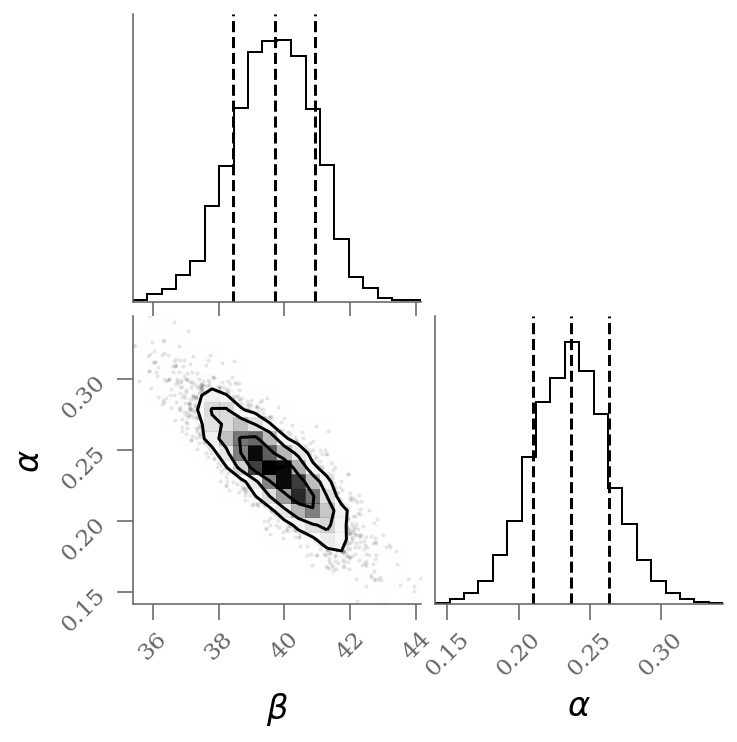

In [ ]:
corner(sample, labels=(r'$\beta$', r'$\alpha$'), quantiles=(0.16, 0.50, 0.84));

Without outlier modeling:
* $\alpha$ = 39.7 [38.4, 40.9]
* $\beta$ = 0.237 [0.21, 0.263]


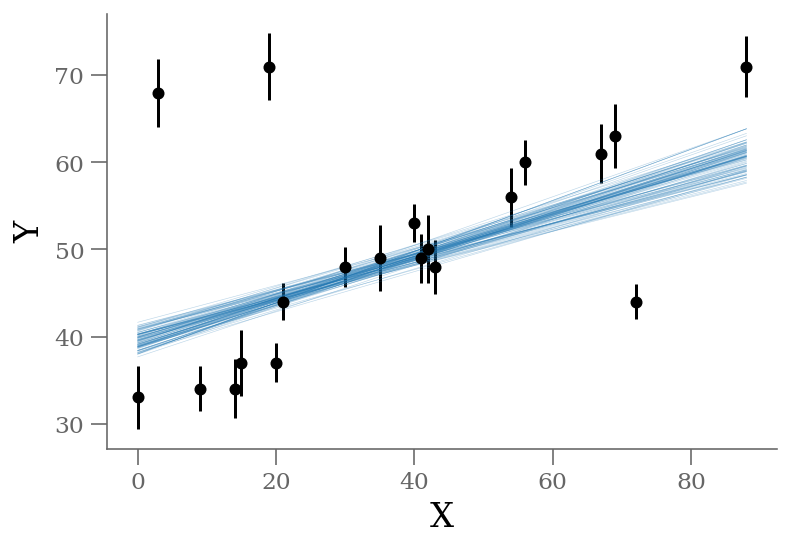

In [ ]:
x, y, sy = np.loadtxt('line_outlier.dat', unpack=True)
plt.errorbar(x, y, yerr=sy, marker='o', ls='None', ms=5, color='k');
plt.xlabel('X');
plt.ylabel('Y');
ypred_blind = sample[:, 0] + sample[:, 1] * x[:, None]
plt.plot(x, ypred_blind[:, :100], color='C0', rasterized=True, alpha=0.3, lw=0.3)

percs_blind = np.percentile(sample, [16, 50, 84], axis=0)
display(Markdown(r"""Without outlier modeling:
* $\alpha$ = {1:0.3g} [{0:0.3g}, {2:0.3g}]
* $\beta$ = {4:0.3g} [{3:0.3g}, {5:0.3g}]
""".format(*percs_blind.T.ravel())
))

It's clear from this plot that the outliers exerts a disproportionate influence on the fit. 

This is due to the nature of our likelihood function. 
One outlier that is, say $10-\sigma$ (standard deviations) away from the fit will out-weight the contribution of points which are only $2-\sigma$ away.

In conclusion, least-square likelihoods are overly sensitive to outliers, and this is causing issues with our fit. 

One way to address this is to simply model the outliers.

## Mixture Model

The Bayesian approach to accounting for outliers generally involves **mixture models** so that the initial model is combined with a complement model accounting for the outliers:

$$P = q \cdot P_{in} + (1 - q) \cdot P_{out},$$

where $q$ is the mixing coefficient (between 0 and 1), $P_{in}$ and $P_{out}$ the probabilities of being an inlier and outlier, respectively.

So let's propose a more complicated model that is a mixture between a *signal* and a *background*

### Graphical model

A short parenthesis on probabilistic programming. One way to represent the above model is through probabilistic graphical models (pgm).

Using `daft` a python package, I draw a (inaccurate) pgm of the straight line model with outliers.

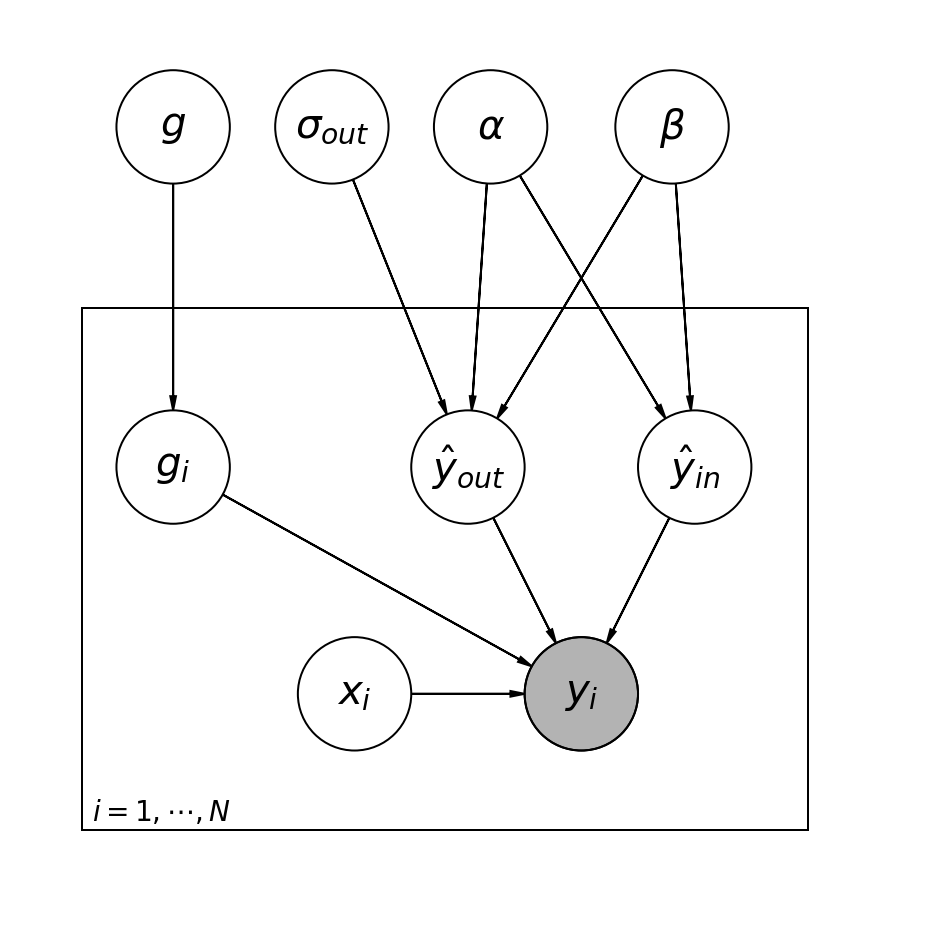

In [ ]:
import daft

# Instantiate the PGM.
pgm = daft.PGM([4, 4], origin=[-0.5, -0.0], grid_unit=4, 
               node_unit=2, label_params=dict(fontsize='x-large'))

# Hierarchical parameters.
pgm.add_node(daft.Node("sout", r"$\sigma_{out}$", 0.9, 3.5, fixed=False))
pgm.add_node(daft.Node("g", r"$g$", 0.2, 3.5, fixed=False))
pgm.add_node(daft.Node("beta", r"$\beta$", 2.4, 3.5))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.6, 3.5))

# Latent variable.
pgm.add_node(daft.Node("x", r"$x_i$", 1, 1))
pgm.add_node(daft.Node("gn", r"$g_i$", 0.2, 2, observed=False))
pgm.add_node(daft.Node("yin", r"$\hat{y}_{in}$", 2.5, 2, observed=False))
pgm.add_node(daft.Node("yout", r"$\hat{y}_{out}$", 1.5, 2, observed=False))

# Data.
pgm.add_node(daft.Node("y", r"$y_i$", 2, 1, observed=True))

# And a plate.
pgm.add_plate(daft.Plate([-0.2, 0.5, 3.2, 2.2], 
                         label=r"$i = 1, \cdots, N$", shift=-0.1,
                         bbox={"color": "none"}))

# add relations
pgm.add_edge("x", "y")
pgm.add_edge("alpha", "yin")
pgm.add_edge("beta", "yin")
pgm.add_edge("alpha", "yout")
pgm.add_edge("beta", "yout")
pgm.add_edge("sout", "yout")
pgm.add_edge("g", "gn")
pgm.add_edge("gn", "y")
pgm.add_edge("yin", "y")
pgm.add_edge("yout", "y")

pgm.render();

There are multiple ways to define this mixture modeling. 

### Brutal version: 1 parameter per datapoint

$$P_i = q_i \cdot P_{in, i} + (1 - q_i) \cdot P_{out, i},$$

$P_{in, i}$ corresponds to the previous likelihood.

$P_{out, i}$ is arbitrary as we do not really have information about the causes for the outliers. We assume a similar Gaussian form centered on the affine relation but with a significantly larger dispersion.
Doing so is intuitively considering the distance to the line to decide whether we have an outlier or not (this is intuitively a Bayesian version of sigma-clipping)

It is important to note that the total likelihood is a product of sums:
$$ P = \prod_i P_i = \prod_i \left(q_i \cdot P_{in, i} + (1 - q_i) \cdot P_{out, i}\right).$$
Hence, we need to be careful to properly transform the $\ln P$ into $P$ during the calculations (see: `np.logsumexp`)

Hence the likelihood becomes explicitly
$$
\begin{array}{ll}
P(\{x_i\}, \{y_i\}~|~\theta,\{q_i\},\{\sigma_i\}, \sigma_{out}) = & \frac{q_i}{\sqrt{2\pi \sigma_i^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_i^2}\right] \\
&+ \frac{1 - q_i}{\sqrt{2\pi \sigma_{out}^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_{out}^2}\right].
\end{array}
$$

We "simply" expanded our model with $20$ nuisance parameters: $\{q_i\}$ is a series of weights, which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. 

$q_i=0$ indicates an outlier, in which case a Gaussian of width $\sigma_{out}$ is used in the computation of the likelihood. This $\sigma_{out}$ can also be a nuisance parameter.
However, for this example, we fix $\sigma_{out}$ to an arbitrary large value (large compared with the dispersion of the data)

Note that we have a prior that all $q_i$ must be strictly between 0 and 1.

We code the likelihood (using Theano) as:

In [ ]:
def logp_signoise(yobs, is_outlier, ypred_in, sigma_y_in, ypred_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers.
    '''

    # likelihood for inliers
    dy_in = yobs - ypred_in + 1e-4   ##  constant for numeric stability
    
    logL_in = (
        T.log(1 - is_outlier) -
        0.5 * (dy_in / sigma_y_in) ** 2 - 
        0.5 * T.log(2 * np.pi * sigma_y_in ** 2)
    )

    # likelihood for outliers
    dy_out = yobs - ypred_out + 1e-4
    sy_out_2 = sigma_y_in ** 2 + sigma_y_out ** 2
    logL_out = (
        T.log(is_outlier) -
        0.5 * (dy_out ** 2 / sy_out_2) - 
        0.5 * T.log(2 * np.pi * sy_out_2)
    )

    return T.sum(T.log(T.exp(logL_in) + T.exp(logL_out)))

Our likelihood can be expressed directly with tensor operations (otherwise we'd need to use theano's `@as_op`
decorator). This means we get the likelihood gradient for free thanks to the Theano backend, which makes the MCMC sampler more efficient (HMC methods)

We now make the probabilistic equations that link the various variables together:

We would like to fit a linear model to this above dataset:

$$ \hat{y}_{in}(x ~\mid~\alpha, \beta) = \alpha x + \beta $$

One must provide some prior to properly implement the model. Let's suppose weak informative normal priors (they correspond to a Ridge regression context)

$$ \alpha \rightsquigarrow \mathcal{U}(0, 100) $$
$$ \beta \rightsquigarrow \mathcal{U}(0, 100) $$

We also have the outlier component $\hat{y}_{out}$
$$ \hat{y}_{out} \rightsquigarrow \mathcal{N}(\hat{y}_{out}, \sigma_{out})$$
where $\sigma_{out}$ is unknown but positively constrained (half-Normal prior)
$$ \sigma_{out} \rightsquigarrow \mathcal{N^+}(0, 100)$$

And each data point has a Bernoulli probability (0 or 1) to be an outlier or not with a probability $g$
$$ g_i \rightsquigarrow \mathcal{B}(g) $$

$g$ sets the ratio of inliers to outliers. Given our setup, it corresponds to the fraction of outliers in our model. One can set a wealky informative prior on $g$ as
$$ g \rightsquigarrow \mathcal{U}(0, 0.5) $$
(hopefully we do not have more than half of the data being made of outliers)


Our final model is a mixture of the two components:

$$ y_i ~\mid~ \hat{y}_{in}, \hat{y}_{out}, \sigma_y, \sigma_{out} \rightsquigarrow 
(1 - g_i) \, \mathcal{N}(\hat{y}_{in}, \sigma_y) + g_i \, \mathcal{N}(\hat{y}_{out}, \sigma_{out})$$

we code the probabilistic model as follow (using `DensityDist` to set the final mixture likelihood)

In [ ]:
with pm.Model() as mdl_signoise:

    ## Define weakly informative Normal priors 
    beta = pm.Uniform('beta', 0, 100, testval=pm.floatX(0.1))
    alpha = pm.Uniform('alpha', 0, 100, testval=pm.floatX(1.))

    ## Define linear model
    ypred_in = beta + alpha * x

    ## Define weakly informative priors for the mean and 
    ## variance of outliers
    sigma_y_out = 100
    ypred_out = pm.Normal('ypred_out', mu=0, sd=sigma_y_out,
                          testval=pm.floatX(1.))
    

    ## Define Bernoulli inlier / outlier flags according to 
    ## a hyperprior fraction of outliers, itself constrained
    ## to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers,
                              shape=len(x),
                              testval=np.random.rand(len(x)) < 0.2)

    ## Extract observed y and sigma_y from dataset, 
    ## encode as theano objects
    yobs = thno.shared(np.asarray(y, dtype=thno.config.floatX),
                       name='yobs')
    sigma_y_in = thno.shared(
        np.asarray(sy, dtype=thno.config.floatX), 
        name='sigma_y_in')

    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist(
        'likelihood', logp_signoise,
        observed={'yobs': yobs, 
                  'is_outlier': is_outlier,
                  'ypred_in': ypred_in, 
                  'sigma_y_in': sigma_y_in,
                  'ypred_out': ypred_out, 
                  'sigma_y_out': sigma_y_out})

In [ ]:
with mdl_signoise:
    ## take samples
    traces_signoise = pm.sample(20000, tune=10000, progressbar=True,
                                compute_convergence_checks=False,
                                return_inferencedata=True,
                                idata_kwargs=dict(density_dist_obs=False))
# note: idata_kwargs=dict(density_dist_obs=False) is a bug from DensityDist

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [frac_outliers, ypred_out, alpha, beta]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 186 seconds.


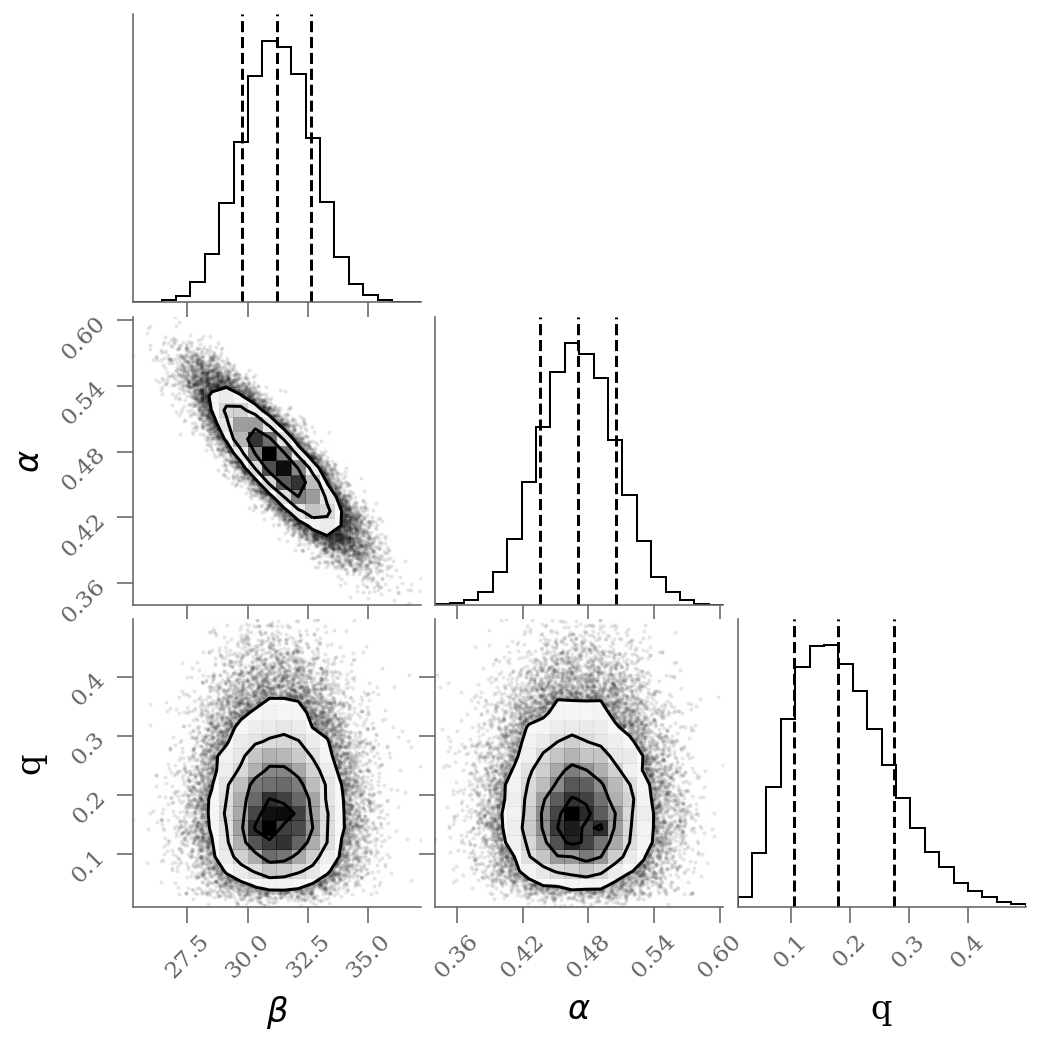

In [ ]:
varnames = 'beta', 'alpha', 'frac_outliers'
sample = np.array([traces_signoise.posterior[k].values.ravel() for k in varnames]).T

corner(sample[:, :], labels=(r'$\beta$', r'$\alpha$', r'q'), quantiles=(0.16, 0.50, 0.84));

We see a distribution of points near a slope of $\sim 0.45$, and an intercept of $\sim 31$. We'll plot this model over the data below, but first let's see what other information we can extract from this trace.

One nice feature of analyzing MCMC samples is that the choice of nuisance parameters is completely irrelevant during the sampling.

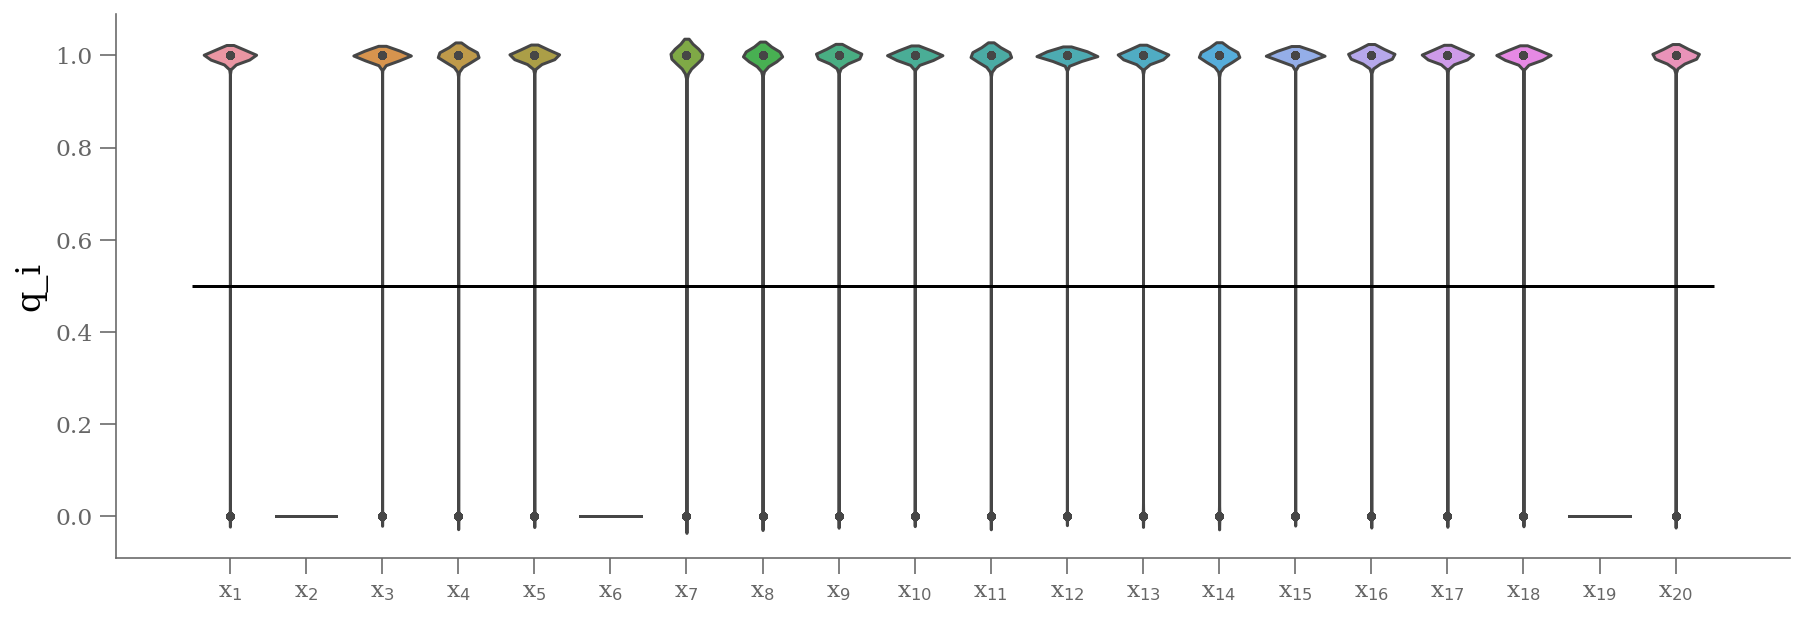

In [ ]:
import pandas as pd
import seaborn as sns

# is_outlier = 1 - q
samples_q = 1 - traces_signoise.posterior.is_outlier.values.reshape(-1, 20)
# making a dictionary to plot faster
d = {}
for k in range(samples_q.shape[1]):
    d[r'x$_{{{0:d}}}$'.format(k+1)] = samples_q[:, k]
df = pd.DataFrame.from_dict(d)

plt.figure(figsize=(15, 5))
sns.violinplot(data=df, inner="points")
plt.hlines([0.5], *plt.xlim());
plt.ylabel('q_i');

Without outlier modeling:
* $\alpha$ = 39.7 [38.4, 40.9]
* $\beta$ = 0.237 [0.21, 0.263]


With outlier modeling: 22 parameters
* $\alpha$ = 31.2 [29.8, 32.6]
* $\beta$ = 0.47 [0.436, 0.505]
* number of outliers: $3$


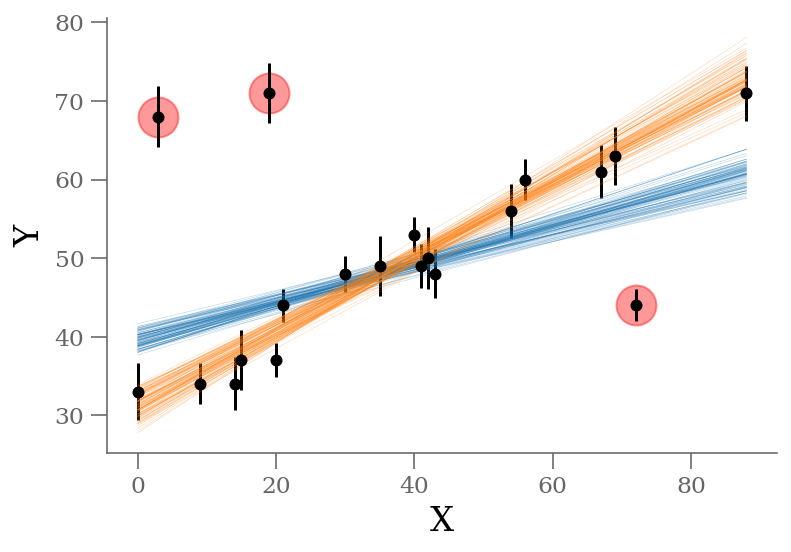

In [ ]:
q = np.median(samples_q, 0)
outliers = (q <= 0.5)  # arbitrary choice
n_outliers = sum(outliers)

x, y, sy = np.loadtxt('line_outlier.dat', unpack=True)
plt.errorbar(x, y, yerr=sy, marker='o', ls='None', ms=5, color='k');
ypred_brute = sample[:, 0] + sample[:, 1] * x[:, None]

plt.plot(x, ypred_blind[:, :100], color='C0', rasterized=True, alpha=0.3, lw=0.3)
plt.plot(x, ypred_brute[:, :100], color='C1', rasterized=True, alpha=0.3, lw=0.3)
plt.plot(x[outliers], y[outliers], 'ro', 
         ms=20, mec='red', mfc='red', zorder=1, alpha=0.4)

plt.xlabel('X');
plt.ylabel('Y');


display(Markdown(r"""Without outlier modeling:
* $\alpha$ = {1:0.3g} [{0:0.3g}, {2:0.3g}]
* $\beta$ = {4:0.3g} [{3:0.3g}, {5:0.3g}]
""".format(*percs_blind.T.ravel())
))

percs_brute = np.percentile(sample[:, :2], [16, 50, 84], axis=0)
display(Markdown(r"""With outlier modeling: 22 parameters
* $\alpha$ = {1:0.3g} [{0:0.3g}, {2:0.3g}]
* $\beta$ = {4:0.3g} [{3:0.3g}, {5:0.3g}]
* number of outliers: ${6:d}$
""".format(*percs_brute.T.ravel(), n_outliers)
))

The result shown in orange matches our intuition. In addition, the points automatically identified as outliers are the ones we would identify by eye to be suspicious. The blue shaded region indicates the previous "blind" result.

### The smarter version

This previous model of outliers takes a simple linear model of $2$ parameters and transforms it into a $(N+2)$ parameters, $N$ being the number of datapoints. This leads to $22$ parameters in our case. What happens if you have $200$ data points? 

The problem with the previous model was that it adds one parameter for each data point, which not only makes the fitting expensive, but also makes the problem untracktable very quickly.

Based on the same formulation, we can consider one global $q$ instead individuals, which will characterize on the ensemble the probability of having an outlier. In other words, the fraction of outliers relative to the dataset. 

$$ P = \prod_i P_i = \prod_i \left(q \cdot P_{in, i} + (1 - q) \cdot P_{out, i}\right).$$

with

$$
\begin{array}{ll}
p(\{x_i\}, \{y_i\}~|~\theta,q,\{\sigma_i\}, \sigma_{out}) = & \frac{q}{\sqrt{2\pi \sigma_i^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_i^2}\right] \\
&+ \frac{1 - q}{\sqrt{2\pi \sigma_{out}^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_{out}^2}\right]
\end{array}
$$



We simply have $1$ nuisance parameters: $q$ which ranges from 0 to 1.

Similarly to the previous model, $q=0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter.

From this model, we can estimate the odds of being an outlier with
$$ Odds_{outlier}(x_i, y_i, \sigma_i) = \frac{(1-q) P(x_i, y_i | \sigma_{out})}{q\,P(x_i, y_i | \sigma_i, \alpha, \beta) + (1-q) P(x_i, y_i | \sigma_{out})}$$

Our likelihood can be expressed directly with tensor operations (otherwise we'd need to use theano's `@as_op`
decorator). This means we get the likelihood gradient for free thanks to the Theano backend, which makes the MCMC sampler more efficient (HMC methods)

We now make the probabilistic equations that link the various variables together:

We would like to fit a linear model to this above dataset:

$$ \hat{y}_{in}(x ~\mid~\alpha, \beta) = \alpha x + \beta $$

One must provide some prior to properly implement the model. Let's suppose weak informative normal priors (they correspond to a Ridge regression context)

$$ \alpha \rightsquigarrow \mathcal{U}(0, 100) $$
$$ \beta \rightsquigarrow \mathcal{U}(0, 100) $$

We also have the outlier component $\hat{y}_{out}$
$$ \hat{y}_{out} \rightsquigarrow \mathcal{N}(\hat{y}_{out}, \sigma_{out})$$
where $\sigma_{out}$ is unknown but positively constrained (half-Normal prior)
$$ \sigma_{out} \rightsquigarrow \mathcal{N^+}(0, 100)$$

$g$ sets the ratio of inliers to outliers. Given our setup, it corresponds to the fraction of outliers in our model. One can set a wealky informative prior on $g$ as
$$ g \rightsquigarrow \mathcal{U}(0, 0.5) $$
(hopefully we do not have more than half of the data being made of outliers)


Our final model is a mixture of the two components:

$$ y_i ~\mid~ \hat{y}_{in}, \hat{y}_{out}, \sigma_y, \sigma_{out} \rightsquigarrow 
(1 - g) \, \mathcal{N}(\hat{y}_{in}, \sigma_y) + g \, \mathcal{N}(\hat{y}_{out}, \sigma_{out})$$

we code the probabilistic model as follow (using `DensityDist` to set the final mixture likelihood)

In [ ]:
def logp_smart(yobs, is_outlier, ypred_in, sigma_y_in, ypred_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers.
    '''

    # likelihood for inliers
    dy_in = yobs - ypred_in + 1e-4   ##  constant for numeric stability
    
    logL_in = (
        T.log(1 - is_outlier) -
        0.5 * (dy_in / sigma_y_in) ** 2 - 
        0.5 * T.log(2 * np.pi * sigma_y_in ** 2)
    )

    # likelihood for outliers
    dy_out = yobs - ypred_out + 1e-4
    sy_out_2 = sigma_y_in ** 2 + sigma_y_out ** 2
    logL_out = (
        T.log(is_outlier) -
        0.5 * (dy_out ** 2 / sy_out_2) - 
        0.5 * T.log(2 * np.pi * sy_out_2)
    )

    return T.sum(T.log(T.exp(logL_in) + T.exp(logL_out)))


with pm.Model() as mdl_smart:

    ## Define weakly informative Normal priors 
    beta = pm.Uniform('beta', 0, 100, testval=pm.floatX(0.1))
    alpha = pm.Uniform('alpha', 0, 100, testval=pm.floatX(1.))

    ## Define linear model
    ypred_in = beta + alpha * x

    ## Define weakly informative priors for the mean and 
    ## variance of outliers
    sigma_y_out = 100
    ypred_out = pm.Normal('ypred_out', mu=0, sd=sigma_y_out,
                          testval=pm.floatX(1.))
    

    ## Define Bernoulli inlier / outlier flags according to 
    ## a hyperprior fraction of outliers, itself constrained
    ## to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5, testval=0.3)

    ## Extract observed y and sigma_y from dataset, 
    ## encode as theano objects
    yobs = thno.shared(np.asarray(y, dtype=thno.config.floatX),
                       name='yobs')
    sigma_y_in = thno.shared(
        np.asarray(sy, dtype=thno.config.floatX), 
        name='sigma_y_in')

    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist(
        'likelihood', logp_smart,
        observed={'yobs': yobs, 
                  'is_outlier': frac_outliers,
                  'ypred_in': ypred_in, 
                  'sigma_y_in': sigma_y_in,
                  'ypred_out': ypred_out, 
                  'sigma_y_out': sigma_y_out})

In [ ]:
with mdl_smart:
    ## take samples
    traces_smart = pm.sample(20000, tune=10000, progressbar=True,
                             compute_convergence_checks=False,
                             return_inferencedata=True,
                             idata_kwargs=dict(density_dist_obs=False))
# note: idata_kwargs=dict(density_dist_obs=False) is a bug from DensityDist

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [frac_outliers, ypred_out, alpha, beta]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 100 seconds.


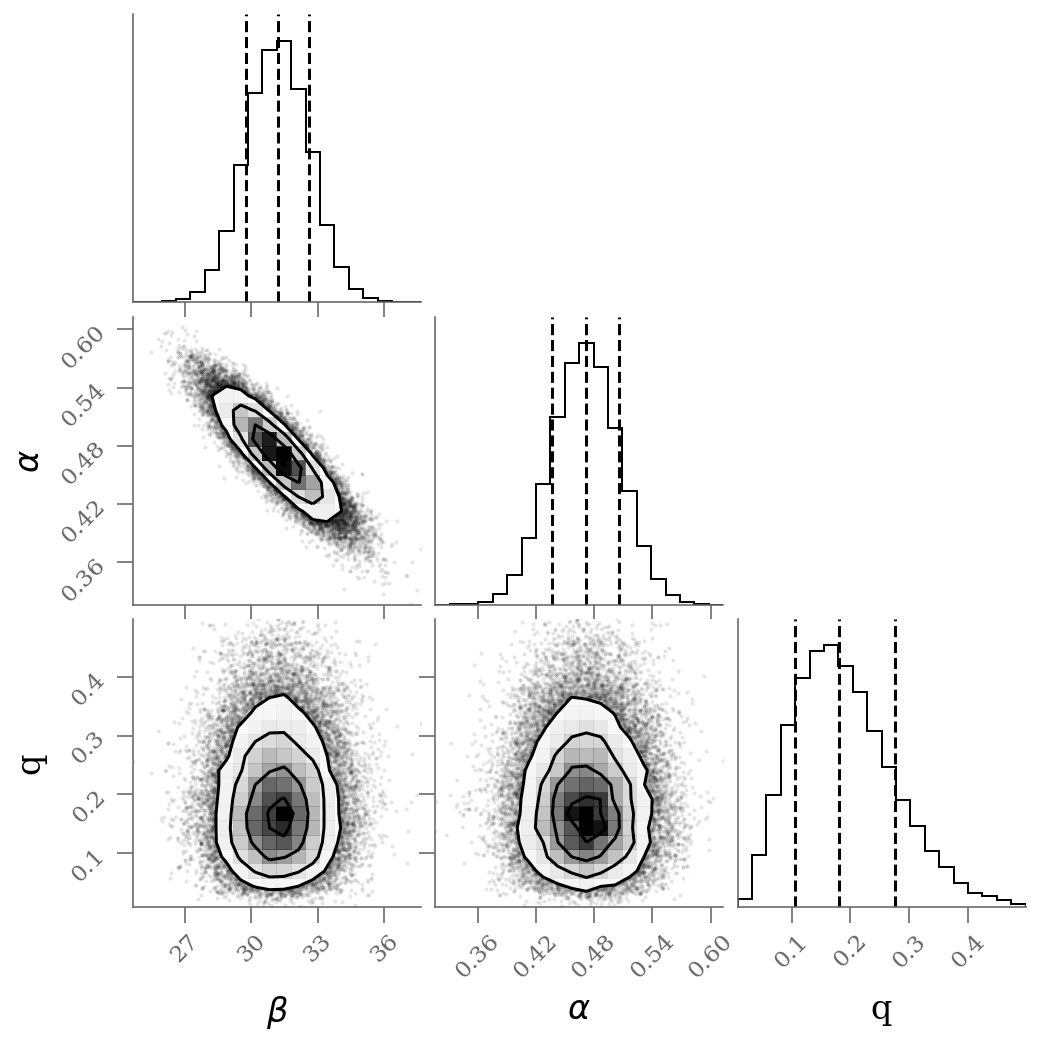

In [ ]:
varnames = 'beta', 'alpha', 'frac_outliers'
sample = np.array([traces_smart.posterior[k].values.ravel() for k in varnames]).T

corner(sample[:, :], labels=(r'$\beta$', r'$\alpha$', r'q'), quantiles=(0.16, 0.50, 0.84));

In [ ]:
def odds_outlier_full(theta, x, y, sy):
    """ Odds of being an outlier
    """
    beta, alpha = theta[:2]

    q = float(theta[2])
    if (np.any(q > 1) | np.any(q < 0)):
        return 0
    # q<0 or q>1 leads to NaNs in logarithm
    q = np.clip(q, 1e-4, 1-1e-4)
    
    if alpha < 0:
        return 0

    def lnp(theta, x, y, sy):
        """log-likelihood"""
        dy = y - theta[0] - theta[1] * x
        logL = -0.5 * np.log(2 * np.pi * sy ** 2) - 0.5 * ( dy / sy) ** 2
        return logL
    
    sout = 100
    lnp_in = lnp(theta, x, y, sy)
    lnp_out = lnp(theta, x, y, sout)
    lntot = np.logaddexp(np.log(q) + lnp_in, np.log(1-q) + lnp_out)
    return np.exp(np.log(1-q) + lnp_out) / np.exp(lntot)

Without outlier modeling (blue):
* $\alpha$ = 39.7 [38.4, 40.9]
* $\beta$ = 0.237 [0.21, 0.263]


With outlier modeling (orange): 22 parameters
* $\alpha$ = 31.2 [29.8, 32.6]
* $\beta$ = 0.47 [0.436, 0.505]
* number of outliers: $3$


With outlier modeling (green): 3 parameters
* $\alpha$ = 31.2 [29.8, 32.6]
* $\beta$ = 0.471 [0.436, 0.506]
* $q$ = 0.18 [0.106, 0.276]
* number of outliers: $3$


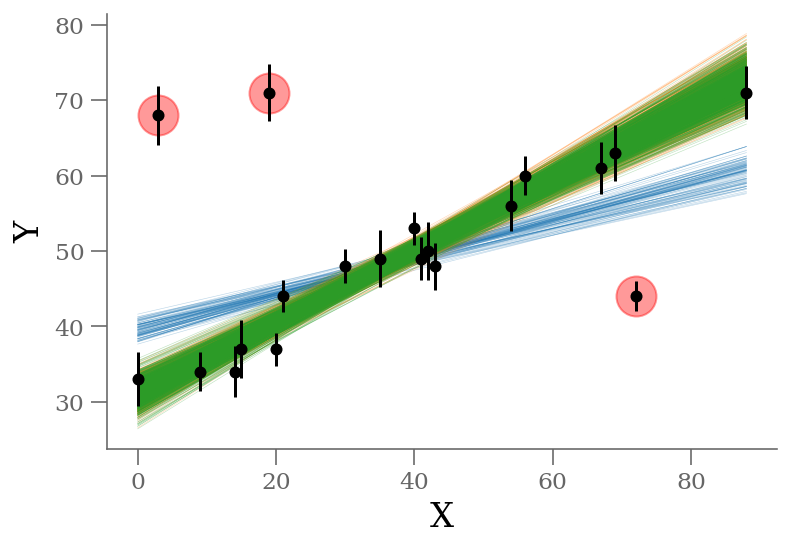

In [ ]:
outliers = odds_outlier_full(np.median(sample, axis=0), x, y, sy) >= 0.5
n_outliers = sum(outliers)

x, y, sy = np.loadtxt('line_outlier.dat', unpack=True)
plt.errorbar(x, y, yerr=sy, marker='o', ls='None', ms=5, color='k');
ypred_smart = sample[:, 0] + sample[:, 1] * x[:, None]

plt.plot(x, ypred_blind[:, :100], color='C0', 
         rasterized=True, alpha=0.3, lw=0.3, zorder=-3)
plt.plot(x, ypred_brute[:, :1000], color='C1', 
         rasterized=True, alpha=0.3, lw=0.3, zorder=-2)
plt.plot(x, ypred_smart[:, :1000], color='C2', 
         rasterized=True, alpha=0.3, lw=0.3, zorder=-1)
plt.plot(x[outliers], y[outliers], 'ro', 
         ms=20, mec='red', mfc='red', zorder=1, alpha=0.4)

plt.xlabel('X');
plt.ylabel('Y');


display(Markdown(r"""Without outlier modeling (blue):
* $\alpha$ = {1:0.3g} [{0:0.3g}, {2:0.3g}]
* $\beta$ = {4:0.3g} [{3:0.3g}, {5:0.3g}]
""".format(*percs_blind.T.ravel())
))

display(Markdown(r"""With outlier modeling (orange): 22 parameters
* $\alpha$ = {1:0.3g} [{0:0.3g}, {2:0.3g}]
* $\beta$ = {4:0.3g} [{3:0.3g}, {5:0.3g}]
* number of outliers: ${6:d}$
""".format(*percs_brute.T.ravel(), n_outliers)
))

percs_smart = np.percentile(sample, [16, 50, 84], axis=0)
display(Markdown(r"""With outlier modeling (green): 3 parameters
* $\alpha$ = {1:0.3g} [{0:0.3g}, {2:0.3g}]
* $\beta$ = {4:0.3g} [{3:0.3g}, {5:0.3g}]
* $q$ = {7:0.3g} [{6:0.3g}, {8:0.3g}]
* number of outliers: ${9:d}$
""".format(*percs_smart.T.ravel(), n_outliers)
))

The infered parameters are nearly identical but the convergence is much faster in the last approach.